In [2]:
!pip install librosa soundfile numpy pandas scikit-learn matplotlib seaborn tqdm

In [1]:
import os
import numpy as np
import pandas as pd
import soundfile as sf
import librosa
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


In [2]:
# Map RAVDESS filename codes to emotion labels
emotion_map = {
    '01':'neutral','02':'calm','03':'happy','04':'sad',
    '05':'angry','06':'fearful','07':'disgust','08':'surprise'
}

def load_metadata(base_dir):
    paths, labels = [], []
    for root, _, files in os.walk(base_dir):
        for f in files:
            if not f.endswith('.wav'):
                continue
            parts = f.split('-')
            # modality=03 (audio-only), channel=01 (speech)
            if len(parts) >= 3 and parts[0]=='03' and parts[1]=='01':
                paths.append(os.path.join(root, f))
                labels.append(emotion_map.get(parts[2], 'unknown'))
    return pd.DataFrame({'path': paths, 'emotion': labels})

data_dir = '/kaggle/input/audio-dataset'  # adjust if needed
df = load_metadata(data_dir)

print(f"Loaded {len(df)} files")
print(df.emotion.value_counts())


Loaded 1440 files
emotion
surprise    192
disgust     192
fearful     192
sad         192
happy       192
calm        192
angry       192
neutral      96
Name: count, dtype: int64


In [3]:
def extract_feature(fp, n_mfcc=40, n_mels=128):
    # Read audio
    y, sr = sf.read(fp, dtype='float32')
    if y.ndim > 1:           # stereo → mono
        y = np.mean(y, axis=1)

    # Resample if needed (keyword args)
    if sr != 16000:
        y = librosa.resample(y=y, orig_sr=sr, target_sr=16000)
        sr = 16000

    # Compute STFT for chroma
    stft = np.abs(librosa.stft(y, n_fft=1024, hop_length=512))

    # MFCCs (40)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T, axis=0)
    # Chroma (12)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
    # Mel-spectrogram (128)
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels).T, axis=0)

    # Final feature vector (40 + 12 + 128 = 180 dims)
    return np.hstack([mfcc, chroma, mel])


In [4]:
feature_list = []
for fp in tqdm(df.path, desc="Extracting features"):
    feature_list.append(extract_feature(fp))

X = np.vstack(feature_list)
y = df.emotion.values

print("Feature matrix shape:", X.shape)  # expect (1440, 180)


Extracting features: 100%|██████████| 1440/1440 [01:31<00:00, 15.75it/s]

Feature matrix shape: (1440, 180)


In [5]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


Train shape: (1152, 180) Test shape: (288, 180)
Label mapping: {'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprise': 7}


In [6]:
# If not already installed
!pip install xgboost

In [7]:
# Imports for XGBoost
from xgboost import XGBClassifier

In [8]:
# 1) Instantiate XGBoost (with multiclass logloss and balanced weights)
xgb = XGBClassifier(
    n_estimators=1000,
    max_depth = 4,
    learning_rate=0.05,
    use_label_encoder=True,
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42
)

# 2) Train
xgb.fit(X_train, y_train)

# 3) Predict & report
y_pred_xgb = xgb.predict(X_test)

In [46]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate(name, y_true, y_pred):
    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Generate classification report
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).T

    print(f"\n{name} Classification Report:\n")
    print(report_df.round(2))


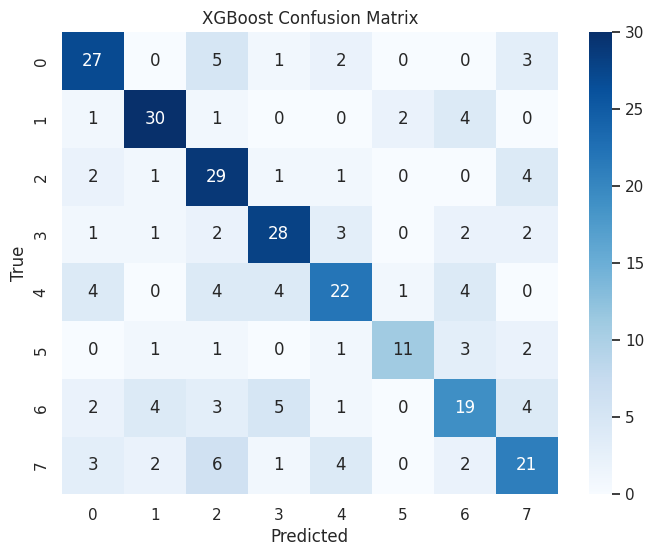


XGBoost Classification Report:

             precision    recall  f1-score support
0                0.855  0.890526      0.87    38.0
1             0.949231  0.969474      0.96    38.0
2             0.748627  0.943158      0.83    38.0
3                 0.88  0.897949      0.89    39.0
4             0.827059  0.744103      0.78    39.0
5             0.965714  0.758947      0.85    19.0
6             0.738824      0.68      0.71    38.0
7             0.763333  0.718462      0.74    39.0
accuracy                              0.83        
macro avg     0.840974  0.825327      0.83   288.0
weighted avg  0.832562  0.829306      0.83   288.0


In [47]:
evaluate("XGBoost",      y_test, xgb.predict(X_test))